In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv("C:/Users/Shush/Final_Sem_Project/Stocks_Data/AAPL_data.csv")

In [9]:
df.head()

,Date,Ticker,Close,High,Low,Open,Volume
0,2024-04-02,AAPL,168.046494,168.544144,167.439360,168.285371,49329500
1,2024-04-03,AAPL,168.852692,169.877850,167.787728,167.996733,47691700
2,2024-04-04,AAPL,168.026611,171.112033,168.026611,169.489689,53704400
3,2024-04-05,AAPL,168.783020,169.589211,168.155976,168.792968,42055200
4,2024-04-08,AAPL,167.658340,168.404816,167.449336,168.235616,37425500


In [7]:
df.columns = df.iloc[0]
df = df[3:].reset_index(drop=True)

# Rename columns
df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
df.insert(1, "Ticker", "AAPL")  # Add Ticker column

# Convert numerical columns to proper types
df["Open"] = df["Open"].astype(float)
df["High"] = df["High"].astype(float)
df["Low"] = df["Low"].astype(float)
df["Close"] = df["Close"].astype(float)
df["Volume"] = df["Volume"].astype(int)


In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.index = df.pop('Date')

In [13]:
# Check for missing values
df.isnull().sum()

Ticker    0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [15]:
df.describe()

,Close,High,Low,Open,Volume
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,218.972342,221.010644,216.652280,218.700512,5.484666e+07
std,22.465400,22.564538,22.096299,22.410232,3.046246e+07
min,164.224564,165.617978,163.308889,164.572913,2.054930e+07
25%,212.642738,215.184998,209.952217,212.525714,3.985705e+07
50%,224.256302,226.331875,222.515348,224.436039,4.807340e+07
75%,232.753716,234.517946,229.477700,232.697865,6.031885e+07
max,258.735504,259.814335,257.347047,257.906429,3.186799e+08


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2024-04-02 to 2025-04-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  251 non-null    object 
 1   Close   251 non-null    float64
 2   High    251 non-null    float64
 3   Low     251 non-null    float64
 4   Open    251 non-null    float64
 5   Volume  251 non-null    int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 12.7+ KB


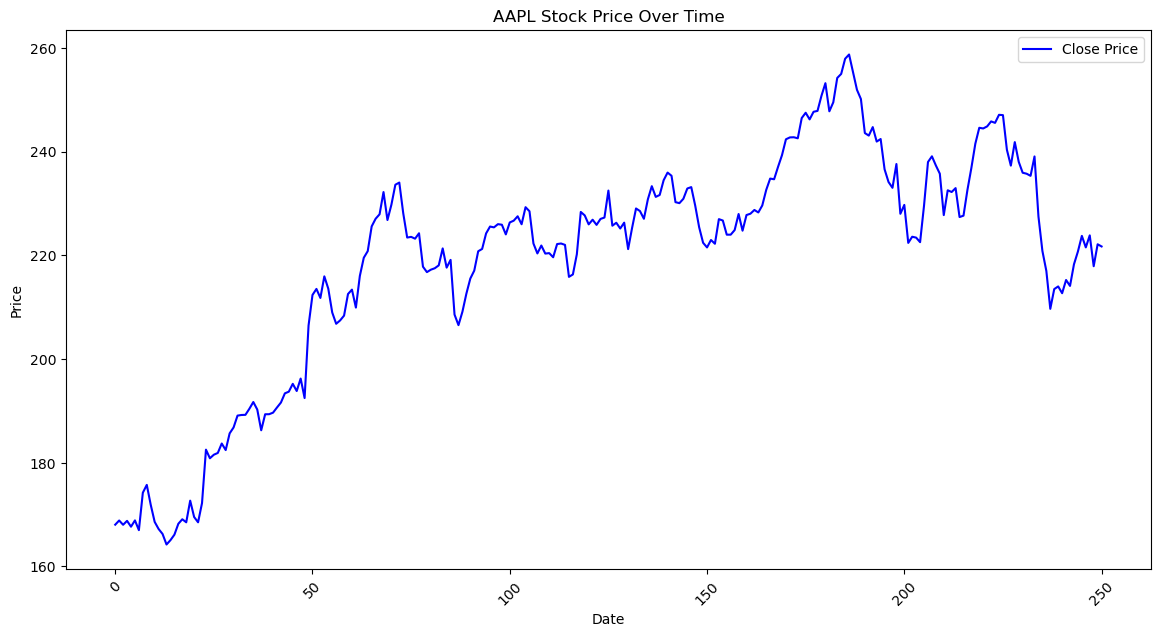

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')


plt.xticks(rotation=45)

plt.title(f"AAPL Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


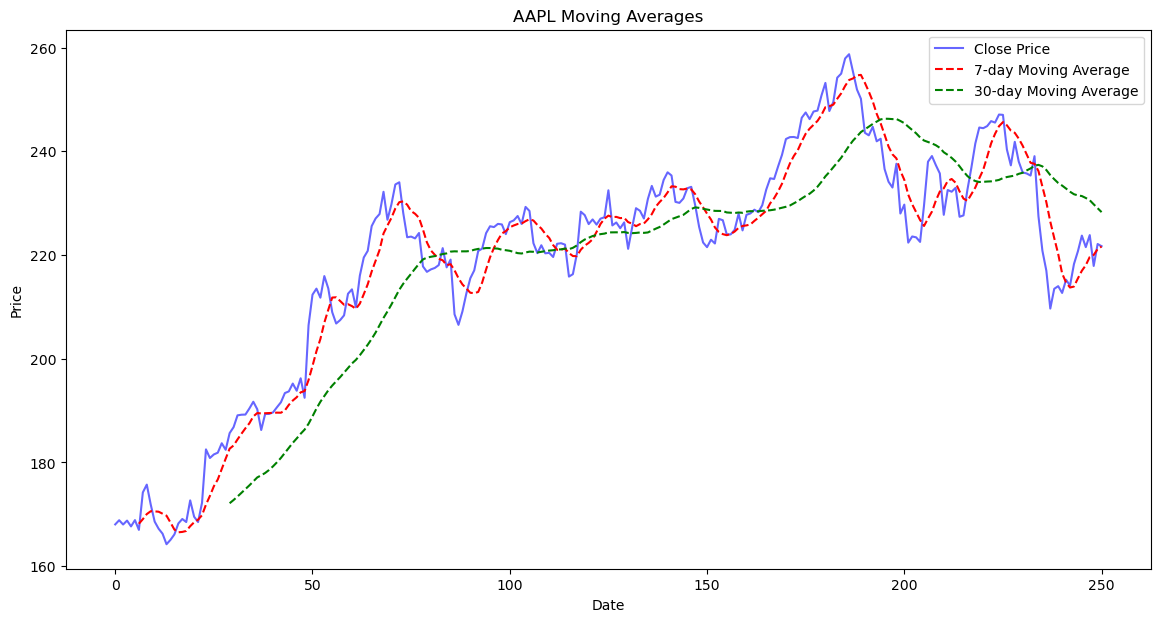

In [13]:
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(df['MA7'], label='7-day Moving Average', color='red', linestyle="dashed")
plt.plot(df['MA30'], label='30-day Moving Average', color='green', linestyle="dashed")
plt.title(f"AAPL Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations']
    out = pd.Series(result[:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    return out

print(adf_test(df['Close']))


ADF Statistic              -2.284712
p-value                     0.176946
# Lags Used                 0.000000
Number of Observations    250.000000
Critical Value (1%)        -3.456781
Critical Value (5%)        -2.873172
Critical Value (10%)       -2.572969
dtype: float64


<Figure size 1400x500 with 0 Axes>

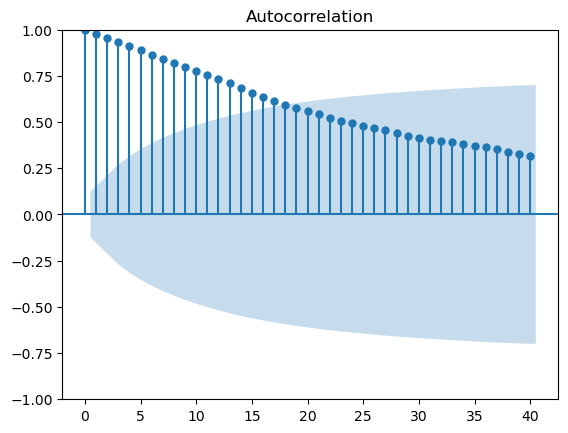

<Figure size 1400x500 with 0 Axes>

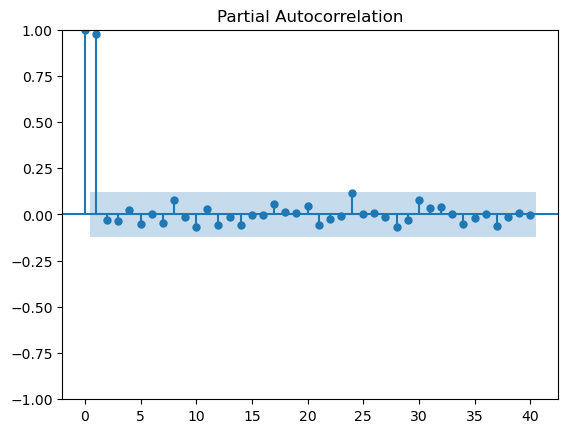

In [17]:
plt.figure(figsize=(14, 5))
plot_acf(df['Close'].dropna(), lags=40)
plt.show()

plt.figure(figsize=(14, 5))
plot_pacf(df['Close'].dropna(), lags=40)
plt.show()

# Preprocessing

In [20]:
df_arima = df[['Close']].copy()
df_arima['Close_diff'] = df_arima['Close'].diff().dropna()  # Differencing
df_arima.dropna(inplace=True)

In [22]:
df_arimax = df[['Close', 'MA7', 'MA30', 'Volume']].copy()
df_arimax.dropna(inplace=True)

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm = df[['Close']].copy()
df_lstm['Scaled_Close'] = scaler.fit_transform(df_lstm[['Close']])

# Creating time-series sequences (lookback = 60 days)
lookback = 60
X, y = [], []
for i in range(lookback, len(df_lstm)):
    X.append(df_lstm['Scaled_Close'].iloc[i-lookback:i].values)
    y.append(df_lstm['Scaled_Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Reshaping for LSTM input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("LSTM Input Shape:", X.shape)


LSTM Input Shape: (191, 60, 1)


In [26]:
train_size = int(len(df) * 0.8)

# Splitting for ARIMA
train_arima, test_arima = df_arima[:train_size], df_arima[train_size:]

# Splitting for ARIMAX
train_arimax, test_arimax = df_arimax[:train_size], df_arimax[train_size:]

# Splitting for LSTM
X_train, X_test, y_train, y_test = X[:train_size-lookback], X[train_size-lookback:], y[:train_size-lookback], y[train_size-lookback:]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Define ARIMA model (using p=2, d=1, q=1) with the help of partial autocorrelation graph
model_arima = ARIMA(train_arima['Close'], order=(2, 1, 1))
model_arima = model_arima.fit()

# Make predictions
pred_arima = model_arima.forecast(steps=len(test_arima))

In [30]:
# Evaluate performance
mae_arima = mean_absolute_error(test_arima['Close'], pred_arima)
print(f"ARIMA MAE: {mae_arima}")

ARIMA MAE: 9.265749516834093


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining ARIMAX model with exogenous features (Volume, MA7, MA30)
model_arimax = SARIMAX(train_arimax['Close'], exog=train_arimax[['Volume', 'MA7', 'MA30']], order=(1, 1, 1))
model_arimax = model_arimax.fit()

# Make predictions
pred_arimax = model_arimax.forecast(steps=len(test_arimax), exog=test_arimax[['Volume', 'MA7', 'MA30']])

In [42]:
mae_arimax = mean_absolute_error(test_arimax['Close'], pred_arimax)
print(f"ARIMAX MAE: {mae_arimax}")

ARIMAX MAE: 5.027385297692579


In [ ]:
# Define LSTM Model
model_lstm = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)  
])

# Compile Model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping (to avoid overfitting)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model_lstm.fit(
    X_train, y_train,
    epochs=10, batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Predict Stock Prices
pred_lstm = model_lstm.predict(X_test)

# Inverse Transform Predictions
pred_lstm = scaler.inverse_transform(pred_lstm.reshape(-1, 1))

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - loss: 0.3584 - val_loss: 0.1309
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0508 - val_loss: 0.0235
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0277 - val_loss: 0.0354
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0203 - val_loss: 0.0125
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0147 - val_loss: 0.0180
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0123 - val_loss: 0.0133
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0117 - val_loss: 0.0144
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0102 - val_loss: 0.0129
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0128 - val_loss: 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


In [46]:
print(f"Shape of actual prices: {test_arima['Close'].shape}")
print(f"Shape of predicted prices: {pred_lstm.shape}")

Shape of actual prices: (50,)
Shape of predicted prices: (51, 1)


In [48]:
pred_lstm = pred_lstm[:len(test_arima)]


In [50]:
mae_lstm = mean_absolute_error(test_arima['Close'], pred_lstm)
print(f"LSTM MAE: {mae_lstm}")

LSTM MAE: 9.083635864257813


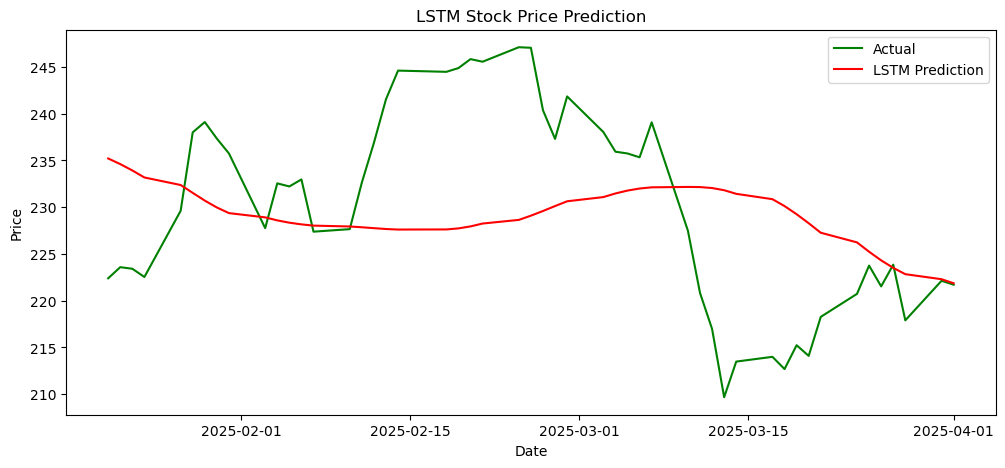

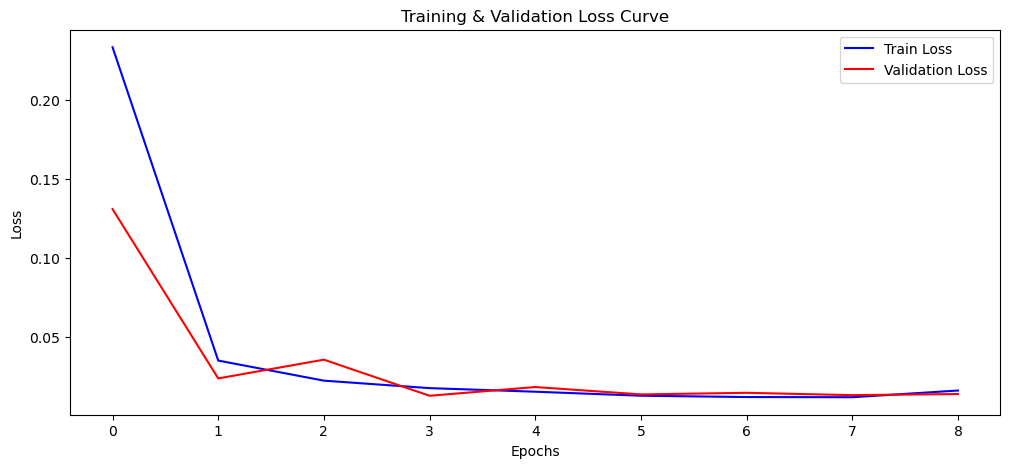

In [52]:
# Plot Predictions vs Actual Prices
plt.figure(figsize=(12, 5))
plt.plot(test_arima.index, test_arima['Close'], label="Actual", color="green")
plt.plot(test_arima.index, pred_lstm, label="LSTM Prediction", color="red")
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot Training & Validation Loss Curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.show()

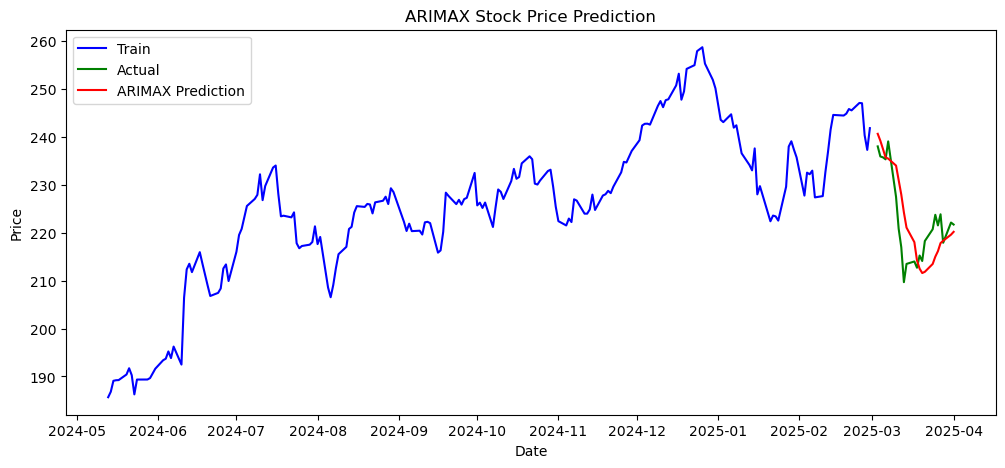

In [54]:
# Plot results
plt.figure(figsize=(12, 5))
plt.plot(train_arimax.index, train_arimax['Close'], label="Train", color="blue")
plt.plot(test_arimax.index, test_arimax['Close'], label="Actual", color="green")
plt.plot(test_arimax.index, pred_arimax, label="ARIMAX Prediction", color="red")
plt.title("ARIMAX Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

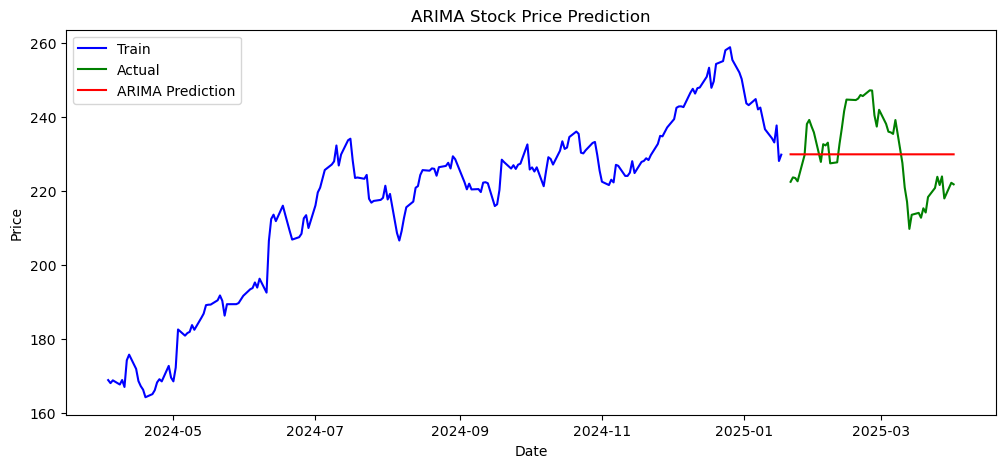

In [56]:
# Plot results
plt.figure(figsize=(12, 5))
plt.plot(train_arima.index, train_arima['Close'], label="Train", color="blue")
plt.plot(test_arima.index, test_arima['Close'], label="Actual", color="green")
plt.plot(test_arima.index, pred_arima, label="ARIMA Prediction", color="red")
plt.title("ARIMA Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# Create 30 business days from last date
full_data = pd.concat([train_arimax, test_arimax])
future_dates = pd.bdate_range(start=full_data.index[-1] + pd.Timedelta(days=1), periods=30)

# Simulate future volume: extrapolate trend or add small noise
future_volume = full_data['Volume'].rolling(3).mean().iloc[-1] + np.random.normal(0, 1, 30)


extended_close = pd.concat([
    full_data['Close'],
    pd.Series([full_data['Close'].iloc[-1]] * 30, index=future_dates)
])


future_ma7 = extended_close.rolling(window=7).mean().iloc[-30:]
future_ma30 = extended_close.rolling(window=30).mean().iloc[-30:]


future_exog = pd.DataFrame({
    'Volume': future_volume,
    'MA7': future_ma7.values,
    'MA30': future_ma30.values
}, index=future_dates)

In [129]:
forecast_future = model_arimax.forecast(steps=30, exog=future_exog)
forecast_future.index = future_dates

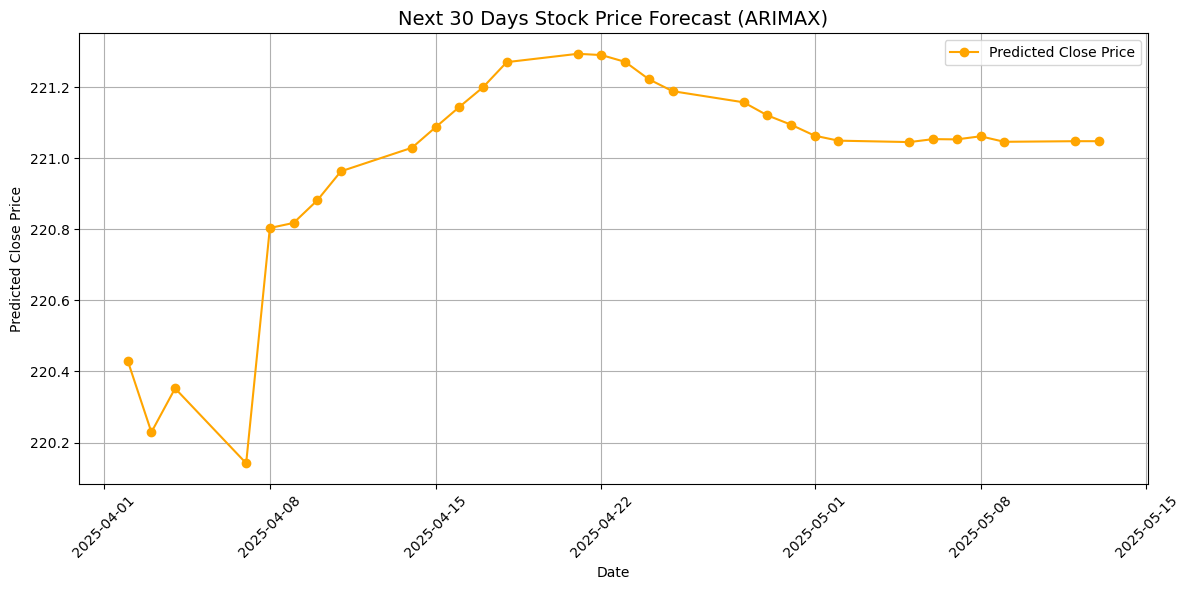

In [133]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_future.index, forecast_future, color='orange', marker='o', label='Predicted Close Price')
plt.title('Next 30 Days Stock Price Forecast (ARIMAX)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [141]:
joblib.dump(model_arimax,'arimax_model_AAPL.pkl')
print(f"Model saved at arimax_model_AAPL.pkl")

Model saved at arimax_model_AAPL.pkl
